In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import json
import _pickle as cPickle
import boto3
import io
import pandas as pd

session = boto3.session.Session()


response = s3client.get_object(Bucket='morty0112', Key='20180117_part_one.pkl')
df_0 = pd.read_pickle(io.BytesIO(response['Body'].read()))

In [77]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
'---'.join(df_0.columns)

'doc_id---path---author_code---essay_content---label---unique_lemma---avg_stc_length---total_stc---DT_pos---POS_adjv_body---POS_adjv_repeat_rate---POS_adjv_repeat_cnt---DT_archs---DT_max_dp_cnts---DT_ROOT_idx---DT_pass_cnt---DT_mark_cnt---DT_pos_join---DT_archs_join---DT_insent_pos_ngram---DT_insent_arch_ngram---DT_max_dp_cnts_std---DT_ROOT_idx_mean---DT_pass_cnt_sum---DT_mark_cnt_sum'

# Generate Best Feature -- Doc2Vec representation

In [23]:
train_data, test_data = train_test_split(df_0, train_size=0.8)

col = 'essay_content'
train_docs = pwk.tag_docs(train_data, col, literal=True)
test_docs = pwk.tag_docs(test_data, col, literal=True)
model = pwk.train_doc2vec_model(train_docs, 2, 100)
    
y_train, X_train = pwk.vec_for_learning(model, train_docs)
y_test, X_test = pwk.vec_for_learning(model, test_docs)

# Gridsearch

## Logistic Regression

In [11]:
model = ('lrclf', LogisticRegression())

steps = [
    model
]

grid = {'lrclf__C':[0.001,0.01,0.1,1,10],
        'lrclf__penalty':['l1','l2']
}

pipeline = Pipeline(steps)
gridsearch = GridSearchCV(pipeline,
                          grid,
                          scoring='accuracy',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
print (best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  12 out of  50 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.3s finished


Pipeline(memory=None,
     steps=[('lrclf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [63]:
lrclf = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
lrclf.fit(X_train, y_train)
y_pred = lrclf.predict(X_test)

In [64]:
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,81,1,3,1,1,0,2,0,0,89,0.910112
ENS,0,83,1,0,0,0,1,4,2,91,0.912088
IDN,2,0,66,0,2,0,3,1,3,77,0.857143
JPN,1,3,3,73,3,0,1,0,1,85,0.858824
KOR,5,2,2,8,42,0,3,3,5,70,0.600000
PAK,2,3,0,0,0,69,2,0,2,78,0.884615
PHL,3,2,2,0,1,1,56,4,0,69,0.811594
SIN,2,4,0,0,2,0,1,68,0,77,0.883117
THA,4,4,8,1,5,1,6,0,55,84,0.654762


## Random Forest

In [34]:
model = ('rfclf', RandomForestClassifier())

steps = [
    model
]
random_forest_grid = {'rfclf__max_depth': [None, 5, 10, 20, 50],
                      'rfclf__max_features': ['sqrt', 30, 3, None],
                      'rfclf__min_samples_split': [2, 3, 4],
                      'rfclf__min_samples_leaf': [1, 2, 3,4],
                      'rfclf__criterion': ['gini'],
                      'rfclf__bootstrap': [True],
                      'rfclf__n_estimators': [100]}

pipeline = Pipeline(steps)
gridsearch = GridSearchCV(pipeline,
                         random_forest_grid,
                         n_jobs=-1,
                         cv=5,
                         verbose=1,
                         scoring='accuracy')

gridsearch.fit(X_train, y_train)
best_rf_model = gridsearch.best_estimator_
print (best_rf_model)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.5min finished


Pipeline(memory=None,
     steps=[('rfclf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


### Check Accuracy Improvement via Iteration of different n_estimators choices

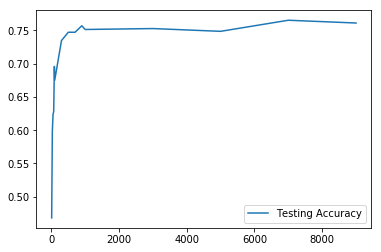

In [39]:
trees = np.sort([(10**j)*i for i in [1, 3, 5, 7, 9] for j in [1, 2, 3]])
accs_train = []
accs_test = []
for t in trees[:]:
    
    rfclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=t, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    
    #rfclf = RandomForestClassifier(n_estimators=t)
    rfclf.fit(X_train, y_train)
    #y_train_pred = rfclf.predict(X_train)
    #accs_train.append(accuracy_score(y_train, y_train_pred))
    y_test_pred = rfclf.predict(X_test)
    accs_test.append(accuracy_score(y_test, y_test_pred))
#plt.plot(trees[:],accs_train, label='Training Accuracy')
plt.plot(trees[:],accs_test, label = 'Testing Accuracy')
plt.legend()
plt.show()

**After iterating over different choices of tree numbers, n_estimator=1000 seems to be the best**

In [70]:
rfclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rfclf.fit(X_train, y_train)
y_pred = rfclf.predict(X_test)

In [71]:
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,69,4,0,2,5,2,1,3,3,89,0.775281
ENS,0,76,1,0,1,0,4,7,2,91,0.835165
IDN,3,1,56,1,1,3,1,3,8,77,0.727273
JPN,4,3,1,67,7,0,0,2,1,85,0.788235
KOR,3,2,2,8,39,1,3,6,6,70,0.557143
PAK,0,3,0,0,1,72,0,1,1,78,0.923077
PHL,3,4,3,0,1,3,44,11,0,69,0.637681
SIN,0,3,1,0,1,0,2,70,0,77,0.909091
THA,3,3,6,3,9,1,4,1,54,84,0.642857


## Gradient Boosting

In [42]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02],
                          'max_depth': [None, 5, 10, 20, 50],
                          'min_samples_leaf': [1, 2, 5],
                          'max_features': [1.0, 0.5],
                          'n_estimators': [100]}

gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
                              gradient_boosting_grid,
                              cv=5,
                              verbose=1,
                              n_jobs=-1,
                              scoring='accuracy')
gbclf_gridsearch.fit(X_train, y_train)
print ("best parameters:", gbclf_gridsearch.best_params_)

best_gbclf_model = gbclf_gridsearch.best_estimator_
print (best_gbclf_model)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 12.5min finished


best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 100}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


### Check Accuracy Improvement via via 'stage_predict()' of GradientBoostingClassifier

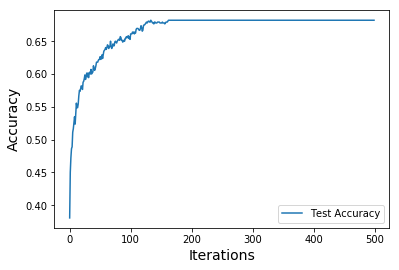

In [72]:
gdb_clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gdb_clf.fit(X_train, y_train)

train_scores = np.zeros((gdb_clf.n_estimators,), dtype=np.float64)
test_scores = np.zeros((gdb_clf.n_estimators,), dtype=np.float64)
for i, y_train_pred in enumerate(gdb_clf.staged_predict(X_train)):
    train_scores[i] = accuracy_score(y_train, y_train_pred)
# Get test score from each boost
for i, y_test_pred in enumerate(gdb_clf.staged_predict(X_test)):
    test_scores[i] = accuracy_score(y_test, y_test_pred)
#plt.plot(train_scores, alpha=.5, label="Train Accuracy")
plt.plot(test_scores, label="Test Accuracy")#ls='--'
#plt.title(name, fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.legend()
plt.show()

**After iterating over different choices of tree numbers, n_estimator=200 seems to be the best**

In [73]:
gdb_clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=0.5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gdb_clf.fit(X_train, y_train)
y_pred = gdb_clf.predict(X_test)
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,70,2,1,3,3,1,3,2,4,89,0.786517
ENS,0,74,1,0,2,1,9,3,1,91,0.813187
IDN,2,0,49,3,3,1,4,2,13,77,0.636364
JPN,4,3,4,57,11,0,0,2,4,85,0.670588
KOR,7,3,2,9,34,3,5,4,3,70,0.485714
PAK,2,3,3,2,2,57,5,1,3,78,0.730769
PHL,4,3,3,0,5,2,45,6,1,69,0.652174
SIN,2,6,1,1,1,1,5,60,0,77,0.779221
THA,3,5,6,6,6,0,5,0,53,84,0.630952


## AdaBoosting

In [59]:
ada_boosting_grid = {'learning_rate': [0.005, 0.01, 0.05, 0.1],
                     'n_estimators': [100]}

adaclf_gridsearch = GridSearchCV(AdaBoostClassifier(), 
                              ada_boosting_grid,
                              cv=5,
                              verbose=1,
                              n_jobs=-1,
                              scoring='accuracy')
adaclf_gridsearch.fit(X_train, y_train)
print ("best parameters:", adaclf_gridsearch.best_params_)

best_adaclf_model = adaclf_gridsearch.best_estimator_
print (best_adaclf_model)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    3.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s finished


best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=None)


### Check Accuracy Improvement via via 'stage_predict()' of AdaBoostClassifier

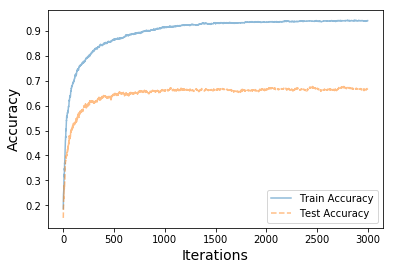

In [75]:
ada_clf = AdaBoostClassifier(algorithm='SAMME.R',
          learning_rate=0.1, n_estimators=3000, random_state=None)
ada_clf.fit(X_train, y_train)

train_scores = np.zeros((ada_clf.n_estimators,), dtype=np.float64)
test_scores = np.zeros((ada_clf.n_estimators,), dtype=np.float64)
for i, y_train_pred in enumerate(ada_clf.staged_predict(X_train)):
    train_scores[i] = accuracy_score(y_train, y_train_pred)
# Get test score from each boost
for i, y_test_pred in enumerate(ada_clf.staged_predict(X_test)):
    test_scores[i] = accuracy_score(y_test, y_test_pred)
plt.plot(train_scores, alpha=.5, label="Train Accuracy")
plt.plot(test_scores, alpha=.5, label="Test Accuracy", ls='--')
#plt.title(name, fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.legend()

**After iterating over different choices of tree numbers, n_estimator=1000 seems to be the best**

In [76]:
ada_clf = AdaBoostClassifier(algorithm='SAMME.R',
          learning_rate=0.1, n_estimators=1000, random_state=None)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,61,2,1,3,17,0,5,0,0,89,0.685393
ENS,0,71,2,0,7,0,6,4,1,91,0.780220
IDN,3,0,52,0,7,0,2,1,12,77,0.675325
JPN,8,2,3,46,23,0,0,0,3,85,0.541176
KOR,4,4,2,5,47,0,4,0,4,70,0.671429
PAK,2,1,9,0,7,46,10,0,3,78,0.589744
PHL,1,5,3,0,4,0,54,1,1,69,0.782609
SIN,4,4,0,0,5,0,5,59,0,77,0.766234
THA,3,4,4,2,30,0,2,0,39,84,0.464286


### Ensembling via Voting

In [82]:
vote_clf1 = VotingClassifier(estimators=[('rf', rfclf), ('gdb', gdb_clf),('ada', ada_clf)], voting='hard')
vote_clf1.fit(X_train, y_train)
y_pred = vote_clf1.predict(X_test)
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,74,3,1,3,5,0,1,1,1,89,0.831461
ENS,0,79,1,0,3,0,3,4,1,91,0.868132
IDN,4,1,56,1,4,1,1,1,8,77,0.727273
JPN,5,5,1,61,11,0,0,1,1,85,0.717647
KOR,6,3,2,6,39,1,5,5,3,70,0.557143
PAK,2,5,4,1,4,59,2,0,1,78,0.756410
PHL,2,8,1,0,0,1,51,6,0,69,0.739130
SIN,4,5,0,0,2,0,3,63,0,77,0.818182
THA,4,6,8,3,12,0,2,0,49,84,0.583333


# Conclusion

### Voting ensemble doesn't help imrove the baseline established by the logistic regression trained by doc2vec matrix. Therefore, doc2vec essay representation training a logistic regression model is the final strategy.